# Biofilm density

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from copy import copy
from datetime import timedelta

In [3]:
datadir = '/scratch/rfischer/Kooi_data/data_output/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [4]:
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

### Read in simulation data

In [5]:
region = 'EqPac'
mortality = 0.39              # [d-1]
runtime = 15                  # [days]
dt = 60                       # [seconds]
outputdt = 6                  # [hours]
death = 'NEMO_detritus'
grazing='full'
mixing = 'markov_0_KPP_reflect'+death+'_tidal'
diss = 0.006
rho_p = 920
rho_bf = [1250, 1388]
sizebinedges = [1e-3, 1e-4, 1e-5]
res = '1x1'
proc = 'bfnoadv'

In [6]:
ds_0 = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+grazing+'_grazing_'+str(diss)[2:]+'diss_'+str(rho_bf[0])+'rhobf_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')
ds_1 = xr.open_dataset(datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+grazing+'_grazing_'+str(diss)[2:]+'diss_'+str(rho_bf[1])+'rhobf_2200rhofr_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc')

In [7]:
dslist = [ds_0, ds_1]

### Split data based on plastic size

In [8]:
split_ds_0 = list(ds_0.groupby_bins('r_pl', sizebinedges[::-1]))
split_ds_1 = list(ds_1.groupby_bins('r_pl', sizebinedges[::-1]))

In [9]:
# mort_cmap = copy(plt.get_cmap('RdPu'))
mort_cmap = ['#FF7917','#14FF37', '#732FFF']
mixing_cmap = ['firebrick','seagreen','purple']
w_vel_cmap = ['salmon', 'lime', 'cornflowerblue', 'gold']
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')
region_cmap = ['teal', 'darkorange', '#9AE19D']

In [10]:
number_of_trajectories_to_plot = 330
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds_0['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds_0['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 330 of 10000 trajectories
plotting every 30 particles


#### Trajectories

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


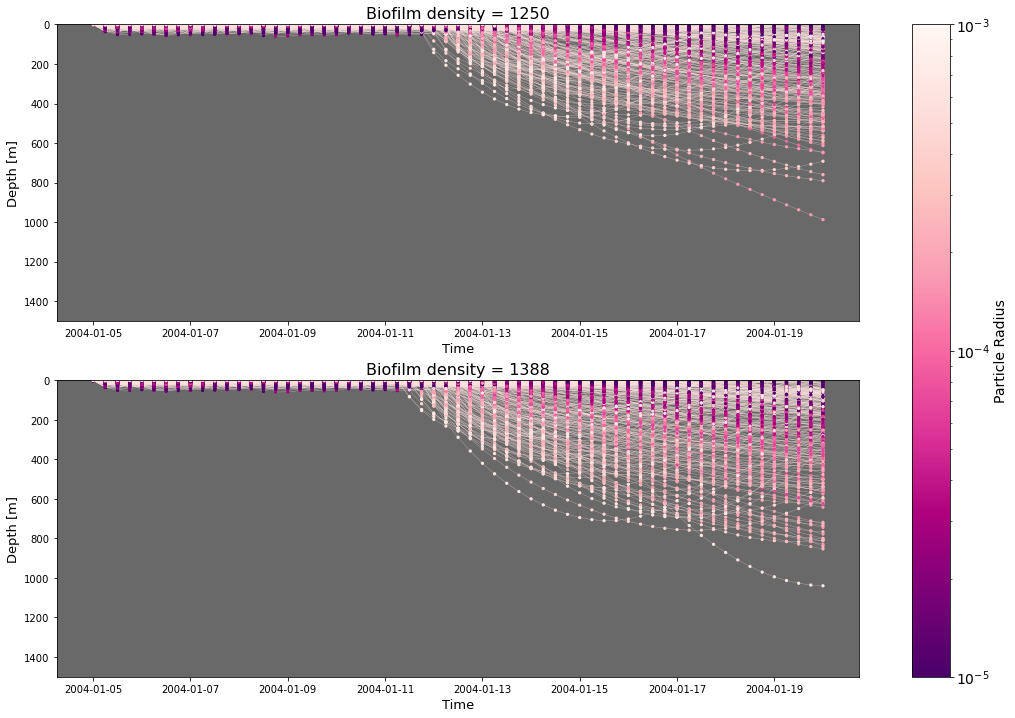

In [11]:
fig = plt.figure(figsize=(16,12),constrained_layout=True)
gs = gridspec.GridSpec(ncols=3, nrows=2, width_ratios=[1,1,0.1],figure=fig)
ax1 = fig.add_subplot(gs[0, :2])
ax2 = fig.add_subplot(gs[1, :2])
ax3 = fig.add_subplot(gs[:, 2])


sc = ax1.scatter(ds_0['time'].T[:,::f_plt], ds_0['z'].T[:,::f_plt], s=5, c=np.tile(ds_0['r_pl'].T[::f_plt],[len(ds_0['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds_0['r_pl'].min(), vmax=ds_0['r_pl'].max()),zorder=2)
ln = ax1.plot(ds_0['time'].T[:,::f_plt], ds_0['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.set_title('Biofilm density = '+str(rho_bf[0]), fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
# ax1.tick_params(axis='x', rotation=45)
ax1.set_facecolor('dimgray')
ax1.set_ylim(1500,0)
# ax1.invert_yaxis()

sc = ax2.scatter(ds_1['time'].T[:,::f_plt], ds_1['z'].T[:,::f_plt], s=5, c=np.tile(ds_1['r_pl'].T[::f_plt],[len(ds_1['obs']),1]),cmap=r_pl_cmap,norm=mcolors.LogNorm(vmin=ds_1['r_pl'].min(), vmax=ds_1['r_pl'].max()),zorder=2)
ln = ax2.plot(ds_1['time'].T[:,::f_plt], ds_1['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax2.set_title('Biofilm density = '+str(rho_bf[1]), fontsize=16)
ax2.set_ylabel('Depth [m]', fontsize=13)
ax2.set_xlabel('Time', fontsize=13)
# ax2.tick_params(axis='x', rotation=45)
ax2.set_facecolor('dimgray')
ax2.set_ylim(1500,0)


cb = fig.colorbar(sc, cax=ax3)
cb.set_label('Particle Radius', fontsize=14)
cb.ax.tick_params(labelsize=14)
plt.show()

#### Depth distribution

In [12]:
depthbins = np.linspace(0,800,200)
starttimes=(ds_0['time'][0,:]-np.timedelta64(int(outputdt/2.), 'h')).values
endtime = (ds_0['time'][0,-1]+np.timedelta64(int(outputdt/2.), 'h')).values
timebins = np.append(starttimes,endtime)

In [13]:
depth_densities = np.zeros((len(dslist),len(split_ds_0),len(dslist[0]['obs']),len(depthbins)-1))

for k in range(len(dslist)):
    split_ds = list(dslist[k].groupby_bins('r_pl',sizebinedges[::-1]))
    for i in range(len(depth_densities)):
        for j in range(len(dslist[k]['obs'])):
            values, bins = np.histogram(split_ds[i][1]['z'].isel(obs=j), depthbins)
            depth_densities[k,i,j] = values/len(split_ds[i][1]['traj'])

Text(0.5, 0.98, 'Particle depth distribution in Equatorial Pacific (logarithmic)')

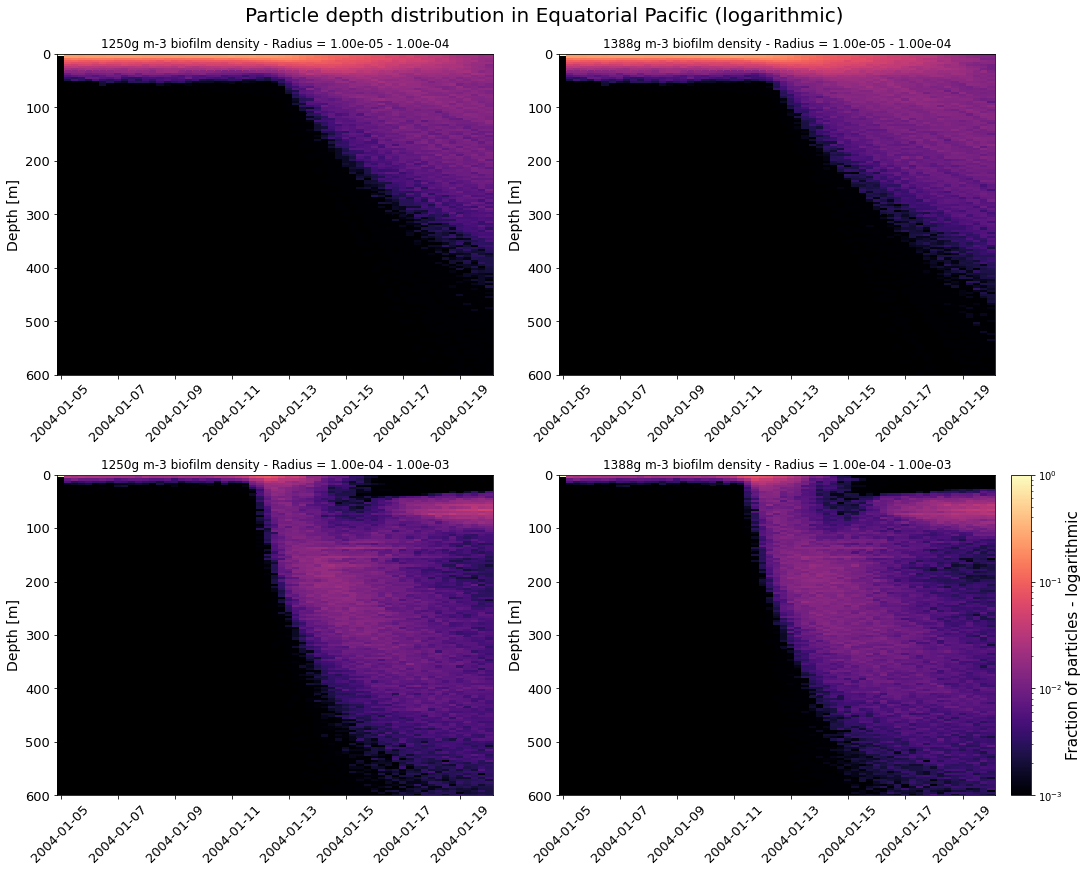

In [16]:
fig = plt.figure(figsize=(15,12),constrained_layout=True)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])
axes = [[ax1, ax2],[ax3,ax4]]

for i, ax_r in enumerate(axes):
    for c, ax in enumerate(ax_r):
        ax.set_facecolor('k')
        pc = ax.pcolormesh(timebins,depthbins,depth_densities[i,c].T, cmap='magma',norm=mcolors.LogNorm(vmin=1e-3, vmax=1))
        #ax.set_title(mixing[0]+' mixing', fontsize=14)
        ax.set_ylabel('Depth [m]', fontsize=14)
        ax.tick_params(axis='both', labelsize=13)
        ax.tick_params(axis='x', rotation=45)
        ax.set_ylim(0, 600)
        ax.invert_yaxis()
        #cb.set_label('Fraction of particles - logarithmic', size=15)
        ax.set_title(str(rho_bf[i])+'g m-3 biofilm density - Radius = '+"{left:.2e} - {right:.2e}".format(left=split_ds[c][0].left, right=split_ds[c][0].right))
        
cb = fig.colorbar(pc) #, cax=ax3)
cb.set_label('Fraction of particles - logarithmic', size=15)
fig.suptitle('Particle depth distribution in '+regions[region]+' (logarithmic)', fontsize=20)